# Lab 5: Spam Detection

**Deadline**: Monday, March 15, 5:00 PM

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Gautam Dawar <gautam.dawar@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

In [2]:
%%shell
jupyter nbconvert --to html /Lab_5_Spam_Detection.ipynb

[NbConvertApp] Converting notebook /Lab_5_Spam_Detection.ipynb to html
[NbConvertApp] Writing 449984 bytes to /Lab_5_Spam_Detection.html


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://colab.research.google.com/drive/1t1Tiydavlvl1d1oCBNo_IEIeE5c7mjtd?usp=sharing


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
for line in open('/SMSSpamCollection'):
    if(line[0] == 'h'):
      print(line)
      break
for line in open('/SMSSpamCollection'):
    if(line[0] == 's'):
      print(line)
      break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



The label for spam message is  **"spam"**

The label for non+spame message is **"ham"**

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam = 0
ham = 0
for line in open('/SMSSpamCollection'):
    if(line[0] == 's'):
      spam += 1
    else:
      ham += 1

print("total spam message is: ", spam)
print("total ham message is: ", ham)

total spam message is:  747
total ham message is:  4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Advantages:**

1. There are only 26 characters in English, for example, but the number of words can be a huge number. So it requires a small range of inputs, and lower the memory needed when processing.
2. When consider words sequence, unseen words may occurred during test, while there won't be unseen characters.

**Disadvantage**

1. words have meaning which can contribute to classify the type of the emails. For example, money is more frequent to be seen in a spam email. However, when train the model according to characters, the meaning of each word get lost and may affect the prediction results.

2. charcters are more than words in an email. So it requires more commutation time.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...
train, valid, test = dataset.split(split_ratio =[0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

If the dataset is unbalanced. Model will realize that non-spam email has a higher possibility to occur in dataset. It will generally put a bias towards non-spam when classifying. It affects the reliability of the model during testting.


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

**stoi:**
mapping each charcter to a number indicating a index for training set.

**itos:** 
mapping each number from the indext for training set to the corresponding characters.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

**unk** represents an unkown character

**pad** represends a token used in incerease the size of the training message, such that all batches will have same length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i = 0
max_length = 0
num_pad = 0
for batch in train_iter:
    if(i < 10):
      for sms_element in batch.sms[0]:
        max_length = max(max_length, len(sms_element))
        for token in sms_element:
          if token == text_field.vocab.stoi["<pad>"]:
            num_pad += 1
      print("Batch# ", i + 1, ": max length is ", max_length, " and the number of <pad> is ", num_pad)
      max_length = 0
      num_pad = 0
      i += 1
    else:
      break

Batch#  1 : max length is  49  and the number of <pad> is  12
Batch#  2 : max length is  146  and the number of <pad> is  20
Batch#  3 : max length is  156  and the number of <pad> is  25
Batch#  4 : max length is  138  and the number of <pad> is  41
Batch#  5 : max length is  32  and the number of <pad> is  19
Batch#  6 : max length is  24  and the number of <pad> is  2
Batch#  7 : max length is  163  and the number of <pad> is  15
Batch#  8 : max length is  51  and the number of <pad> is  24
Batch#  9 : max length is  75  and the number of <pad> is  42
Batch#  10 : max length is  119  and the number of <pad> is  67


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, hidden_size, num_layer = 1, num_classes = 2):
    super(RNN, self).__init__()
    self.emb = torch.eye(vocab_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(vocab_size, hidden_size, num_layer, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    hot_coding = []
    for sms in x:
      hot_coding.append(self.emb[sms])
    input = torch.stack(hot_coding)
    output,_ = self.rnn(input)
    output = torch.max(output, dim = 1)[0]
    output = self.fc(output)
    return output


## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy_loss(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total_num = 0
    for sms, label in data:
      output = model(sms[0])
      pred = output.max(1, keepdim = True)[1]
      correct += pred.eq(label.view_as(pred)).sum().item()
      total_num += label.shape[0]
      output = model(sms[0])
      loss = criterion(output, label)
    return correct / total_num, float(loss)

In [ ]:
def train_net(model, train, valid, batch_size, learning_rate = 1e-4, num_epochs = 5):
    ########################################################################
    # Define the Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        for sms, label in train:
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            output = model(sms[0])
            #calculate the loss
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        train_acc[epoch], train_loss[epoch]= get_accuracy_loss(model, train)
        val_acc[epoch], val_loss[epoch] = get_accuracy_loss(model, valid)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
    print('Finished Training')

    import matplotlib.pyplot as plt
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
val_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

Epoch 1: Train acc: 0.6273577169099557, Train loss: 0.6999562382698059 |Validation acc: 0.3237668161434978, Validation loss: 0.7002593874931335
Epoch 2: Train acc: 0.8969985238641955, Train loss: 0.6681942343711853 |Validation acc: 0.8286995515695067, Validation loss: 0.6506399512290955
Epoch 3: Train acc: 0.9238969985238642, Train loss: 0.4109054207801819 |Validation acc: 0.8905829596412556, Validation loss: 0.5557207465171814
Epoch 4: Train acc: 0.9378382811218632, Train loss: 0.3575499951839447 |Validation acc: 0.9587443946188341, Validation loss: 0.2899458408355713
Epoch 5: Train acc: 0.942102673445957, Train loss: 0.17692930996418 |Validation acc: 0.9506726457399103, Validation loss: 0.2027396708726883
Finished Training


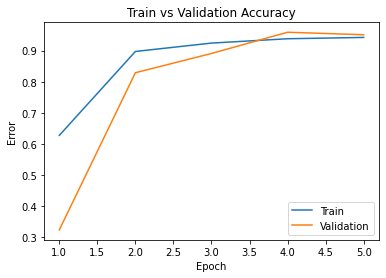

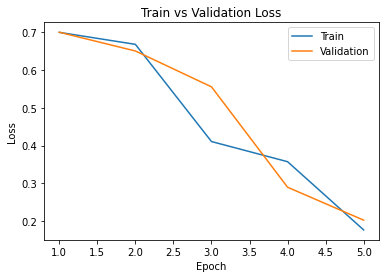

In [ ]:
first_rnn = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos))
train_net(first_rnn, train_iter, val_iter, batch_size= 32, learning_rate=1e-4, num_epochs=5)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

**four hyperparameters: epoch, learning rate, number of layers, combining max pooling with average pooling**

**1. Try epoch = 10: second_rnn**

we get the final accuracy is: Validation acc: 0.9739910313901345

The accuracy increases, so I will use epoch = 10 instead.

**2. Try learning_rate = 1e-5: third_rnn**

get the final accuracy: Validation acc: 0.726457399103139

The accuracy does not improve as the learning_rate lowered. So stay in initial learning rate = 1e-4

**3. Try num_layer = 3: forth_rnn**

get the final accuracy: Validation acc: 0.9695067264573991

So I will stay using 1 layer.

**4. Try combining pooling: fifth_rnn**

get the final accuracy: Validation acc: 0.967713004484305

The accyracy does not improve. So I will stay to use the **second_rnn** as my best model:

**Epoch = 10, learning_rate = 1e-4, num_layer = 1, using single max pooling.**





Epoch 1: Train acc: 0.5942266688535345, Train loss: 0.5809907913208008 |Validation acc: 0.23766816143497757, Validation loss: 0.7220419049263
Epoch 2: Train acc: 0.912743972445465, Train loss: 0.4438171982765198 |Validation acc: 0.874439461883408, Validation loss: 0.6215161085128784
Epoch 3: Train acc: 0.926029194685911, Train loss: 0.16538019478321075 |Validation acc: 0.9695067264573991, Validation loss: 0.3037334680557251
Epoch 4: Train acc: 0.9309496473675578, Train loss: 0.3183663785457611 |Validation acc: 0.9695067264573991, Validation loss: 0.2572445571422577
Epoch 5: Train acc: 0.9365261604067574, Train loss: 0.0684966892004013 |Validation acc: 0.9668161434977578, Validation loss: 0.2653743624687195
Epoch 6: Train acc: 0.9304576020993931, Train loss: 0.3179202675819397 |Validation acc: 0.884304932735426, Validation loss: 0.4016663134098053
Epoch 7: Train acc: 0.9504674430047564, Train loss: 0.6105554103851318 |Validation acc: 0.9704035874439462, Validation loss: 0.11456832289695

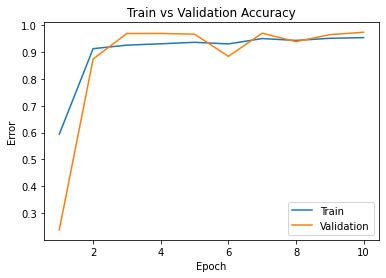

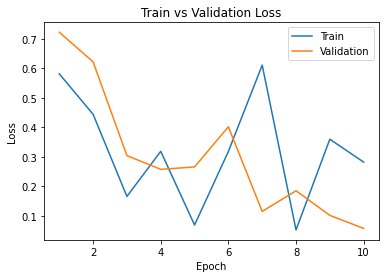

In [ ]:
second_rnn = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos))
train_net(second_rnn, train_iter, val_iter, batch_size= 32, learning_rate=1e-4, num_epochs=10)

In [ ]:
class RNN_comb(nn.Module): # for the fifth_rnn
  def __init__(self, vocab_size, hidden_size, num_layer = 1, num_classes = 2):
    super(RNN_comb, self).__init__()
    self.emb = torch.eye(vocab_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(vocab_size, hidden_size, num_layer, batch_first=True)
    self.fc = nn.Linear(hidden_size * 2, num_classes) #double the hidden size for concatenating max and average pooling

  def forward(self, x):
    hot_coding = []
    for sms in x:
      hot_coding.append(self.emb[sms])
    input = torch.stack(hot_coding)
    output,_ = self.rnn(input)
    output =  torch.cat([torch.max(output, dim=1)[0], 
                 torch.mean(output, dim=1)], dim=1)
    output = self.fc(output)
    return output


### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

In [ ]:
valid_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
false_positive_acc, false_positive_loss = get_accuracy_loss(second_rnn, valid_nospam_iter)
false_negative_acc, false_negative_loss = get_accuracy_loss(second_rnn, valid_spam_iter)
print("the false positive rate is :", (1-false_positive_acc))
print("the false negative rate is :", (1-false_negative_acc))

the false positive rate is : 0.024742268041237137
the false negative rate is : 0.0482758620689655


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**false positive:** consider a nonspam email as spam. this could be a problem when people losing important emails as the output of the algorithm

**false negative:** consider a spam email as nonspam. This does not raise a big issue. But the reciever will be annoyed when recieving spam emails.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
final_test_acc, final_test_loss = get_accuracy_loss(second_rnn, test_iter)
print("the final test accuracy of my model is: ", final_test_acc)

the final test accuracy of my model is:  0.9614003590664273


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    valid.fields)

test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    valid.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_nospam_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
false_positive_acc, false_positive_loss = get_accuracy_loss(second_rnn, test_nospam_iter)
false_negative_acc, false_negative_loss = get_accuracy_loss(second_rnn, test_spam_iter)
print("the false positive rate in test set is :", (1-false_positive_acc))
print("the false negative rate in test set is :", (1-false_negative_acc))

the false positive rate in test set is : 0.040164778578784754
the false negative rate in test set is : 0.027972027972028024


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
msg_indx = []
for char in msg:
  msg_indx.append(torch.tensor(text_field.vocab.stoi[char]))
prediction = second_rnn(torch.stack(msg_indx).unsqueeze_(0))
result = F.softmax(prediction, dim = 1)[0][1].item()
print("the possibility of it to be a spam email is: ", result)
# result = F.softmax(, dim=1)[0][1].item()
# print("The probability of this message to be a spam: ", result)

the possibility of it to be a spam email is:  0.08699739724397659


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

We can use **Naive Bayes Classifier** as a baseline model. (learned from ece368)

Naive Bayes assume that each email's possibility to be spam and ham is totally independent.  And the classifier suggested, we will define a email as spam if it has a high possibility given the word sequence in the email. We will define it as a ham vice versa.

A baseline model can be established heuristically according to this theory. It will calculate two possibilities.

1. the possibility of word sequence occurred in the email if this email is a ham * the prioir possibility of an email to be ham

2. the possibility of word sequence occurred in the email if this email is a spam * the prioir possibility of an email to be spam

the model will then mark the email with the label which has highr probability.

This method does make sense in reality, since spam email will have a high possiblity to contain a word "money". In this case, the possibility of word "money" in spam is much higher than this word in ham. Our classifier will tend to mark this email as a spam email.

